### Init

In [1]:
sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd,warnings
from getting_data import read_conf
import matplotlib.pyplot as plt
from s2search_score_pdp import pdp_based_importance, apply_order
warnings.filterwarnings("ignore")

old_list_idx_map = dict(
    title=0,
    abstract=1,
    venue=2,
    authors=3,
    year=4,
    n_citations=5,
)

old_list = [
    'title', 
    'abstract', 
    'venue', 
    'authors', 
    'year', 
    'n_citations'
]

def get_Z_by_flist(f_list):
    print()
    print(f_list)
    print()
    Z = np.zeros([len(f_list), len(f_list)])

    # load interaction from 2 way ale
    for i in range(len(f_list)):
        f1_name = f_list[i]
        for j in range(i + 1, len(f_list)):
            f2_name = f_list[j]
            
            file = os.path.join('.', 'scores', f'{sample_name}_hs_metrix.npz')
            # hs_metrix = np.load(file)['hs_sqrt_metrix']
            hs_metrix = np.load(file)['hs_metrix']
            
            # hs_metrix = hs_metrix / np.linalg.norm(hs_metrix)
            
            Z[i][j] = hs_metrix[old_list_idx_map[f1_name]][old_list_idx_map[f2_name]]
            Z[j][i] = hs_metrix[old_list_idx_map[f1_name]][old_list_idx_map[f2_name]]
            
    return Z

### Loading data

In [2]:
pd.set_option('display.expand_frame_repr', False)

sample_name = 'cslg-rand-5000'

Z = get_Z_by_flist(old_list)

for a in Z:
    print(a)

def get_wi_order(z):
    order = []
    col = 0
    for row in z:
        vi = row[col]
        other_sij = [*row[0:col], *row[col+1:]]
        sij = np.max(other_sij)
        order.append({
            'feature_name': old_list[col],
            'wi': vi + sij
        })
        col += 1
    
    order.sort(key=lambda x: x['wi'], reverse=True)
    
    return [x['feature_name'] for x in order]

sorted_f_list = get_wi_order(Z / np.linalg.norm(Z))

Z = get_Z_by_flist(sorted_f_list)

for a in Z:
    print(a)

sorted_f_list = [x.title() for x in sorted_f_list]


['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']

[0.         0.25104898 1.03148598 1.04756209 1.03064186 1.03635046]
[0.25104898 0.         0.69292621 0.70520688 0.69568603 0.70204951]
[1.03148598 0.69292621 0.         0.98745316 0.97646948 0.97920658]
[1.04756209 0.70520688 0.98745316 0.         0.98878023 0.99153941]
[1.03064186 0.69568603 0.97646948 0.98878023 0.         1.01395212]
[1.03635046 0.70204951 0.97920658 0.99153941 1.01395212 0.        ]

['title', 'authors', 'n_citations', 'venue', 'year', 'abstract']

[0.         1.04756209 1.03635046 1.03148598 1.03064186 0.25104898]
[1.04756209 0.         0.99153941 0.98745316 0.98878023 0.70520688]
[1.03635046 0.99153941 0.         0.97920658 1.01395212 0.70204951]
[1.03148598 0.98745316 0.97920658 0.         0.97646948 0.69292621]
[1.03064186 0.98878023 1.01395212 0.97646948 0.         0.69568603]
[0.25104898 0.70520688 0.70204951 0.69292621 0.69568603 0.        ]


### Heatmap Plot

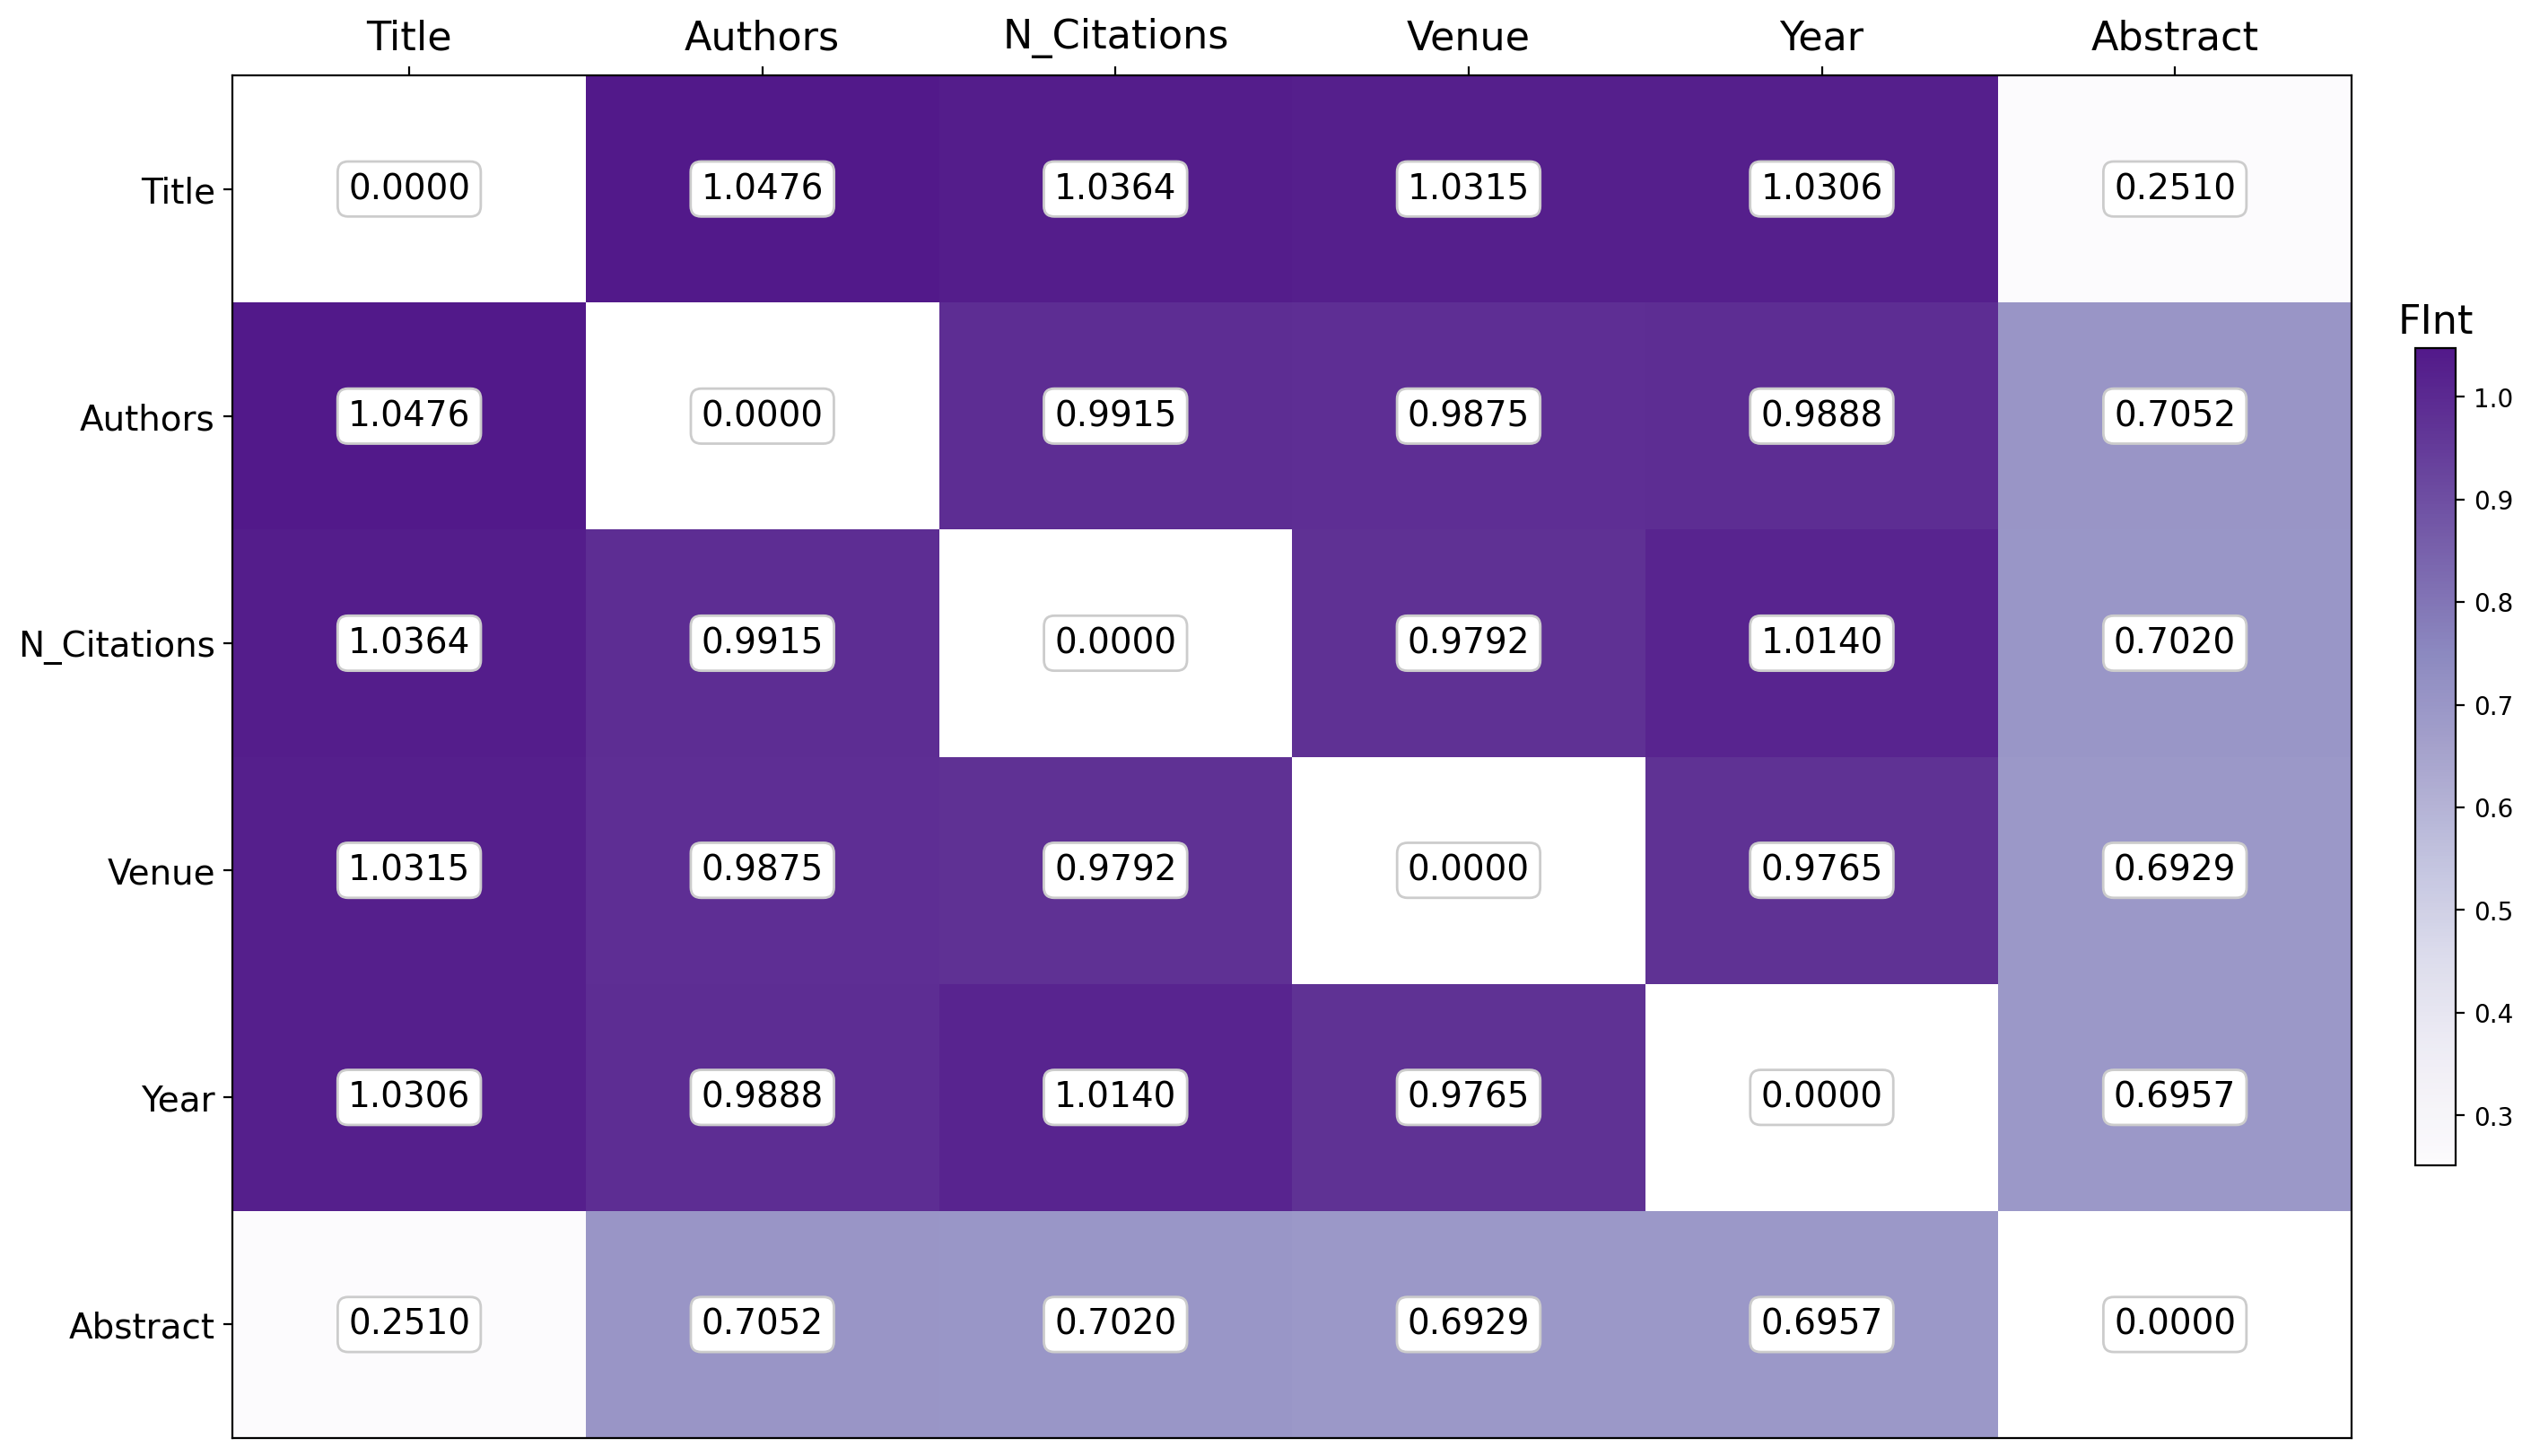

In [3]:
mask= np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1]
]).astype(bool)

z1 = np.copy(Z)
z1[mask] = np.nan

z2 = np.copy(Z)
z2[~mask] = np.nan

z1 = np.flipud(z1)
z2 = np.flipud(z2)

fig, ax = plt.subplots(figsize=(14, 8), dpi=200, constrained_layout=True)

ax.xaxis.tick_top()
ax.set_xticklabels(sorted_f_list, fontsize=16)
ax.set_yticklabels(np.flip(sorted_f_list), fontsize=14)

map1 = ax.pcolormesh(sorted_f_list, np.flip(sorted_f_list), z1,  cmap='Purples', alpha=0.9)
# map2 = ax.pcolormesh(sorted_f_list, np.flip(sorted_f_list), z2,  cmap='Greens', alpha=0.9)

map1cb = fig.colorbar(map1, ax=ax, shrink=0.6, pad=0.03)
map1cb.ax.set_title('FInt', size=16)
# map2cb = fig.colorbar(map2, ax=ax, shrink=0.4, pad=0.03, anchor=(-0.9, 0.1))
# map2cb.ax.set_title('FImp', size=16)

for (i, j), z in np.ndenumerate(np.flipud(Z)):
    ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.8'), size=14)

plt.savefig(os.path.join('.', 'plot', f'{sample_name}-heatmap.png'), facecolor='white', transparent=False, bbox_inches='tight')

### Network Plot

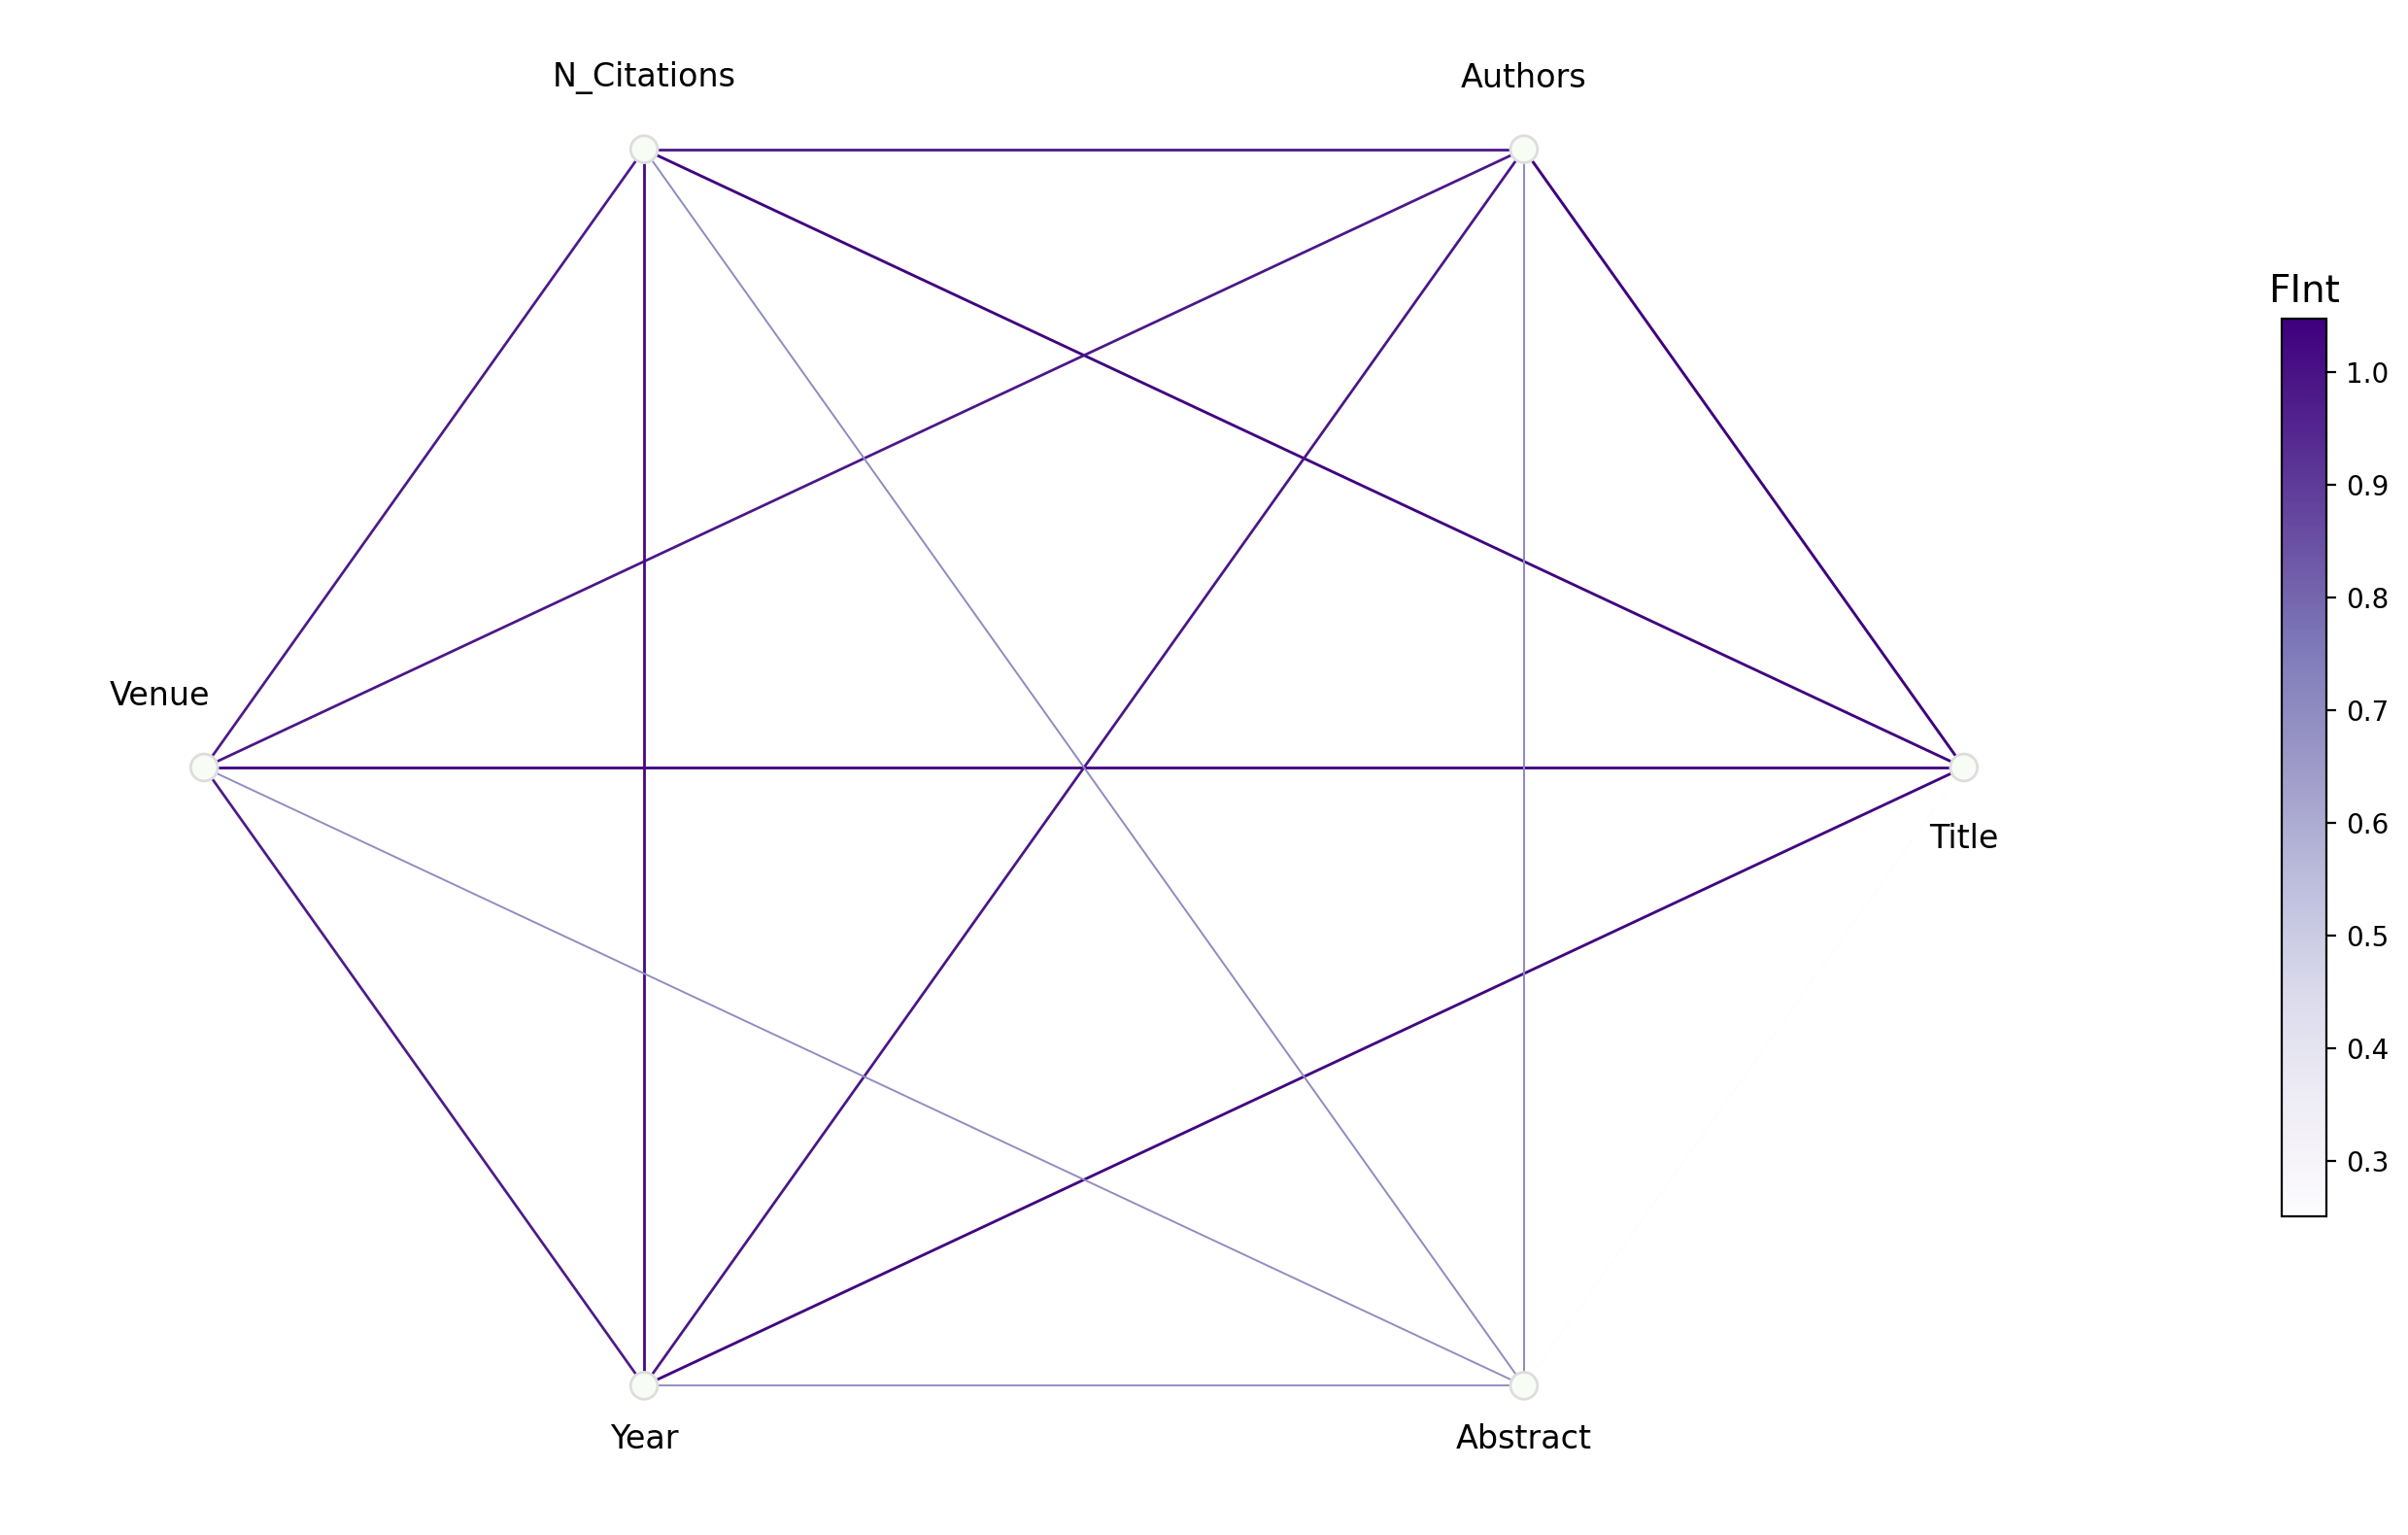

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import math

def plot_net_work(f_list, z1, z2, sl=0, ignore_edges=[], plot_last_name=''):
    f_list = f_list[sl:]
    z1 = np.flipud(z1)
    z2 = np.flipud(z2)
    z1 = z1[sl: , sl:]
    z2 = z2[sl: , sl:]
    plt.figure(figsize=(14,8), dpi=200, facecolor='white', tight_layout=True)
    G = nx.Graph()
    pos_cor = [
        (2,0),
        (1,math.sqrt(3)),
        (-1,math.sqrt(3)),
        (-2,0),
        (-1,-math.sqrt(3)),
        (1,-math.sqrt(3))
    ][sl:]

    pos_cor_2 = [
        (2,-0.2),
        (1,math.sqrt(3) + 0.2),
        (-1,math.sqrt(3) + 0.2),
        (-2.1,0.2),
        (-1,-math.sqrt(3) - 0.15),
        (1,-math.sqrt(3) - 0.15)
    ][sl:]

    pos = {}
    pos_2 = {}
    for i in range(len(f_list)):
        feature_name = f_list[i]
        G.add_nodes_from([(i, {"feature_name": feature_name, 'imp': z2[i][i]})])
        pos[i] = np.array(pos_cor[i])
        pos_2[i] = np.array(pos_cor_2[i])


    edge_widths = []
    edge_colors = []
    for i in range(len(f_list)):
        f1_name = f_list[i]
        for j in range(i + 1, len(f_list)):
            f2_name = f_list[j]
            if f'{f1_name}-{f2_name}'.lower() not in ignore_edges and f'{f2_name}-{f1_name}'.lower() not in ignore_edges:
                G.add_edges_from([(i, j, {'int': (z1)[i][j]})])
                edge_widths.append((z1)[i][j] + (0 if (z1)[i][j] < 1 else 0))
                edge_colors.append((z1)[i][j] + (0 if (z1)[i][j] < 1 and (len(ignore_edges) == 0 and sl == 0)  else 0))

    node_sizes = [100 for x in range(len(f_list))]
    node_colors = [nx.get_node_attributes(G, 'imp').get(x) for x in range(len(f_list))]

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='Greens', edgecolors='#ddd')

    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="-",
        edge_color=edge_colors,
        edge_cmap=plt.cm.get_cmap('Purples'),
        width=edge_widths,
    )

    map2cb = plt.colorbar(edges, shrink=0.6)
    map2cb.ax.set_title('FInt', size=14)

    nodes = nx.draw_networkx_labels(G, pos_2, labels=nx.get_node_attributes(G, 'feature_name'))
    ax = plt.gca()
    ax.set_axis_off()

    plt.savefig(os.path.join('.', 'plot', f'{sample_name}-network_graph_{plot_last_name}.png'), facecolor='white', transparent=False, bbox_inches='tight')
    
plot_net_work(sorted_f_list, z1, z2)

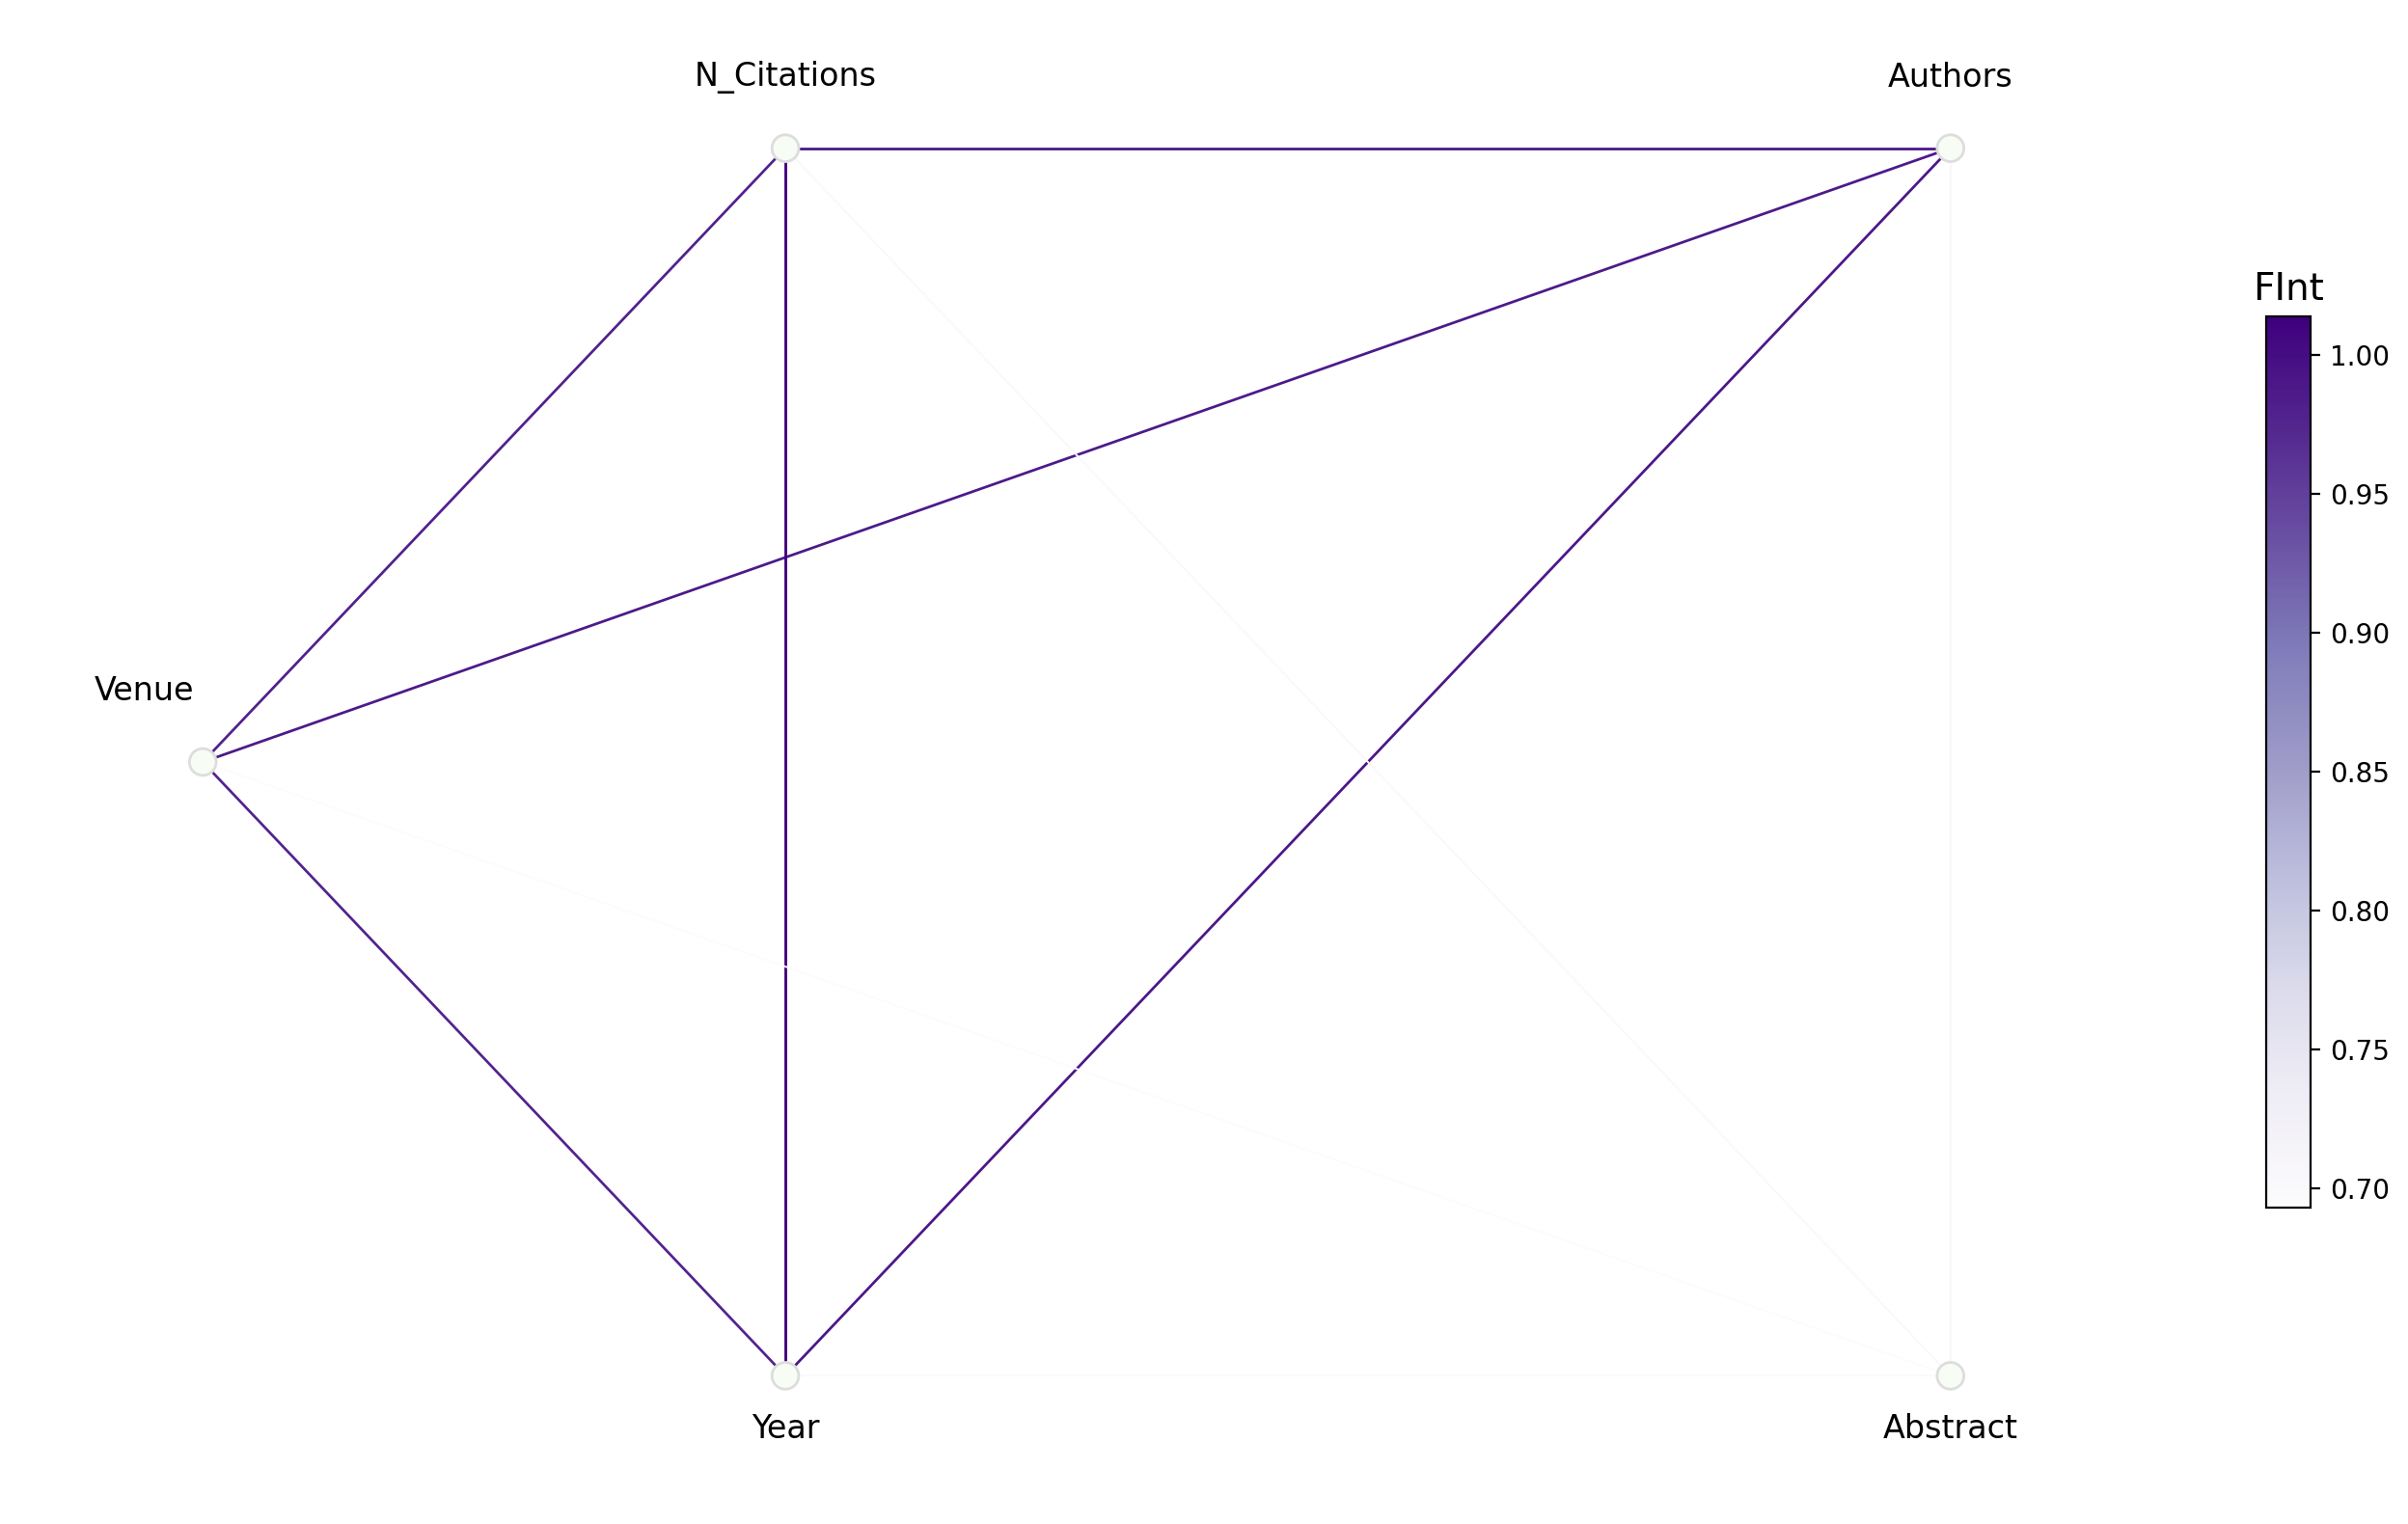

In [5]:
plot_net_work(sorted_f_list, z1, z2, sl=1, plot_last_name='remove_top_node')